#### Loads

In [9]:
import pandas as pd
from DeepRetail.forecasting.statistical import StatisticalForecaster
from DeepRetail.exploratory.eda import get_features
from matplotlib import pyplot as plt
from DeepRetail.evaluation.base import Evaluator
# Import metrics for evaluation
from DeepRetail.evaluation.metrics import rmsse, scaled_error, mape
from DeepRetail.exploratory.eda import get_features
from DeepRetail.transformations.formats import MinMaxScaler_custom
from DeepRetail.forecasting.ml import GlobalForecaster
import lightgbm as lgb
import numpy as np

from DeepRetail.reconciliation.temporal import THieF, TemporalReconciler
from DeepRetail.reconciliation.utils import get_factors
from DeepRetail.reconciliation.cross_sectional import CHieF, CrossSectionalReconciler
from DeepRetail.transformations.formats import hierarchical_to_transaction, extract_hierarchical_structure
from DeepRetail.reconciliation.cross_temporal import CrossTemporalReconciler, C_THieF

In [10]:
# Define metrics
metrics = [rmsse, scaled_error, mape]

In [11]:
df = pd.read_csv('/home/filtheo/DeepRetail/DeepRetail/data/data_folder/supra_month.csv', index_col=0)
df.head()

,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,...,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31
unique_id,,,,,,,,,,,,,,,,,,,,,
GUL-06K,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
GUL-06K11,33.0,20.0,10.0,0.0,18.0,10.0,17.0,15.0,12.0,20.0,...,9.0,11.0,16.0,3.0,18.0,36.0,63.0,8.0,10.0,2.0
GUL-06K12,5.0,5.0,0.0,1.0,0.0,2.0,3.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GUL-06K13,6.0,6.0,0.0,0.0,5.0,8.0,1.0,2.0,3.0,3.0,...,13.0,12.0,7.0,9.0,11.0,7.0,16.0,15.0,6.0,2.0
GUL-06K14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# convert columns to datetime
df.columns = pd.to_datetime(df.columns)

# Drop columns with only nans
df = df.dropna(axis = 0, how = 'all')
df = df.fillna(0)

# Drop rows with only zeros
df = df.loc[~(df==0).all(axis=1)]

# Drop the last month cuz its incomplete
df = df.drop(df.columns[-1], axis = 1)

In [13]:
# Count non zero observations per row on df
non_zero_obs = df.astype(bool).sum(axis=1)

# Total series with over 5 non zero observations
print(len(non_zero_obs))
len(non_zero_obs[non_zero_obs > 5])

384


268

##### Split Data for the two Experiments

In [14]:
# Filter df to only include series with over 5 non zero observations
sample_df = df.loc[non_zero_obs[non_zero_obs > 5].index]
sample_df.shape

(268, 26)

In [15]:
# Will also consider the sample I used on my first experiment.
# The assumption there was that in order to forecast 9 months ahead (6 + 4 cv)
# We would need at least 13 observations

# Count the number of observations and the trailing zeros
obs_count = pd.DataFrame(df.shape[1] - df.isin([0]).sum(axis=1)).rename(columns = {0:'Total_Observations'})
obs_count['Trailing_Zeros'] = df.iloc[:,-9:].isin([0]).sum(axis=1)

# Keep only series with at least 12 non zero observations
observation_threshold = 12
total_vals = 9

# We also do not want all observatios at the end to be zeros!
obs_count_f = obs_count[(obs_count['Total_Observations'] > observation_threshold + total_vals) &  (obs_count['Trailing_Zeros'] < 9)]

# Threshold will be 30
#obs_count_f = obs_count_f[obs_count_f['Total_Observations'] >= 30 ]

# Filtering the df
ids = obs_count_f.reset_index()['unique_id'].unique()

sample_df_2 = df.loc[ids]
sample_df_2.shape # half from the other sample df

(134, 26)

In [16]:
# replace - with _ in the index
sample_df.index = sample_df.index.str.replace('-', '_')
sample_df_2.index = sample_df_2.index.str.replace('-', '_')


sample_df

,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,...,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28
unique_id,,,,,,,,,,,,,,,,,,,,,
GUL_06K11,33.0,20.0,10.0,0.0,18.0,10.0,17.0,15.0,12.0,20.0,...,11.0,9.0,11.0,16.0,3.0,18.0,36.0,63.0,8.0,10.0
GUL_06K12,5.0,5.0,0.0,1.0,0.0,2.0,3.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GUL_06K13,6.0,6.0,0.0,0.0,5.0,8.0,1.0,2.0,3.0,3.0,...,5.0,13.0,12.0,7.0,9.0,11.0,7.0,16.0,15.0,6.0
GUL_06K21,97.0,71.0,48.0,0.0,87.0,94.0,92.0,78.0,80.0,76.0,...,107.0,73.0,98.0,81.0,47.0,62.0,70.0,131.0,61.0,68.0
GUL_06K21A,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TIER_06KF,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0
TIER_06KF1,4.0,2.0,1.0,0.0,3.0,2.0,3.0,4.0,3.0,2.0,...,2.0,0.0,2.0,1.0,1.0,3.0,3.0,6.0,4.0,2.0
TIER_06KF13,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0


#### Basic EDA

In [17]:
features = get_features(sample_df, seasonal_period = 12, periods = 12)
# Use thecustom minmax scaler to normalize lumpiness into 0-1
features['lumpiness'] = MinMaxScaler_custom(features['lumpiness'], feature_range=(0, 1))
features['linearity'] = MinMaxScaler_custom(features['linearity'], feature_range=(0, 1))
features

,unique_id,lumpiness,entropy,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough,Residual_CoV
0,GUL_06K11,0.007289,0.789105,1,12,0.787472,3.040309e-09,0.476362,-0.082485,-0.337632,0.114077,0.999555,12,4,0.987093
1,GUL_06K12,0.579351,0.821091,1,12,0.941332,7.211888e-06,0.163038,1.597819,0.483671,0.236895,0.946198,10,3,0.756467
2,GUL_06K13,0.423431,0.776280,1,12,0.863669,5.821355e-06,0.563582,-1.060916,0.180543,0.034013,0.978570,12,4,0.911323
3,GUL_06K21,0.077706,0.749945,1,12,0.844327,6.650715e-06,0.577228,-0.884772,-0.039580,0.002217,0.981362,12,4,0.964581
4,GUL_06K21A,0.138460,0.783556,1,12,0.672933,4.396312e-05,0.588240,-0.904523,-0.337632,0.114077,0.943225,7,4,0.744441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,TIE_06KB5,0.695402,0.754858,1,12,0.947023,3.806300e-06,0.189938,1.305463,0.457212,0.211843,0.966760,7,4,0.829627
264,TIE_06KB6,0.375458,0.899292,1,12,0.946757,9.942396e-06,0.088505,0.623764,-0.337632,0.114077,0.965019,10,4,0.683560
265,TIE_06KB7,0.009500,0.736328,1,12,0.260843,7.677566e-05,0.478044,-0.631180,-0.448871,0.201494,0.921526,1,11,0.911442
266,TIE_06KB81,0.146166,0.786774,1,12,0.730464,4.375840e-05,0.288925,-0.903468,-0.337632,0.114077,0.943896,3,1,0.958554


In [18]:
# Lumpiness -> the variability of the variability of the series

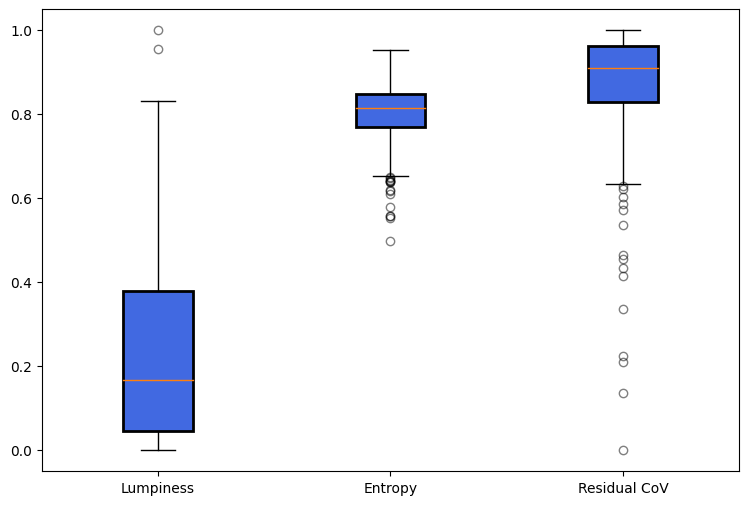

In [19]:
# Three boxplots for lumpiness, entropy and residual_cov on the same figure

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot([features['lumpiness'], features['entropy'], features['Residual_CoV']], patch_artist=True)

# Make the boxplot darkblue and the lines black
for box in bp['boxes']:
    # change outline color
    box.set( color='black', linewidth=2)
    # change fill color to dark blue
    box.set( facecolor = 'royalblue' )

# change the outlier colors
for flier in bp['fliers']:
    flier.set(marker='o', color='black', alpha=0.5)


# Give names
ax.set_xticklabels(['Lumpiness', 'Entropy', 'Residual CoV'])

plt.show()

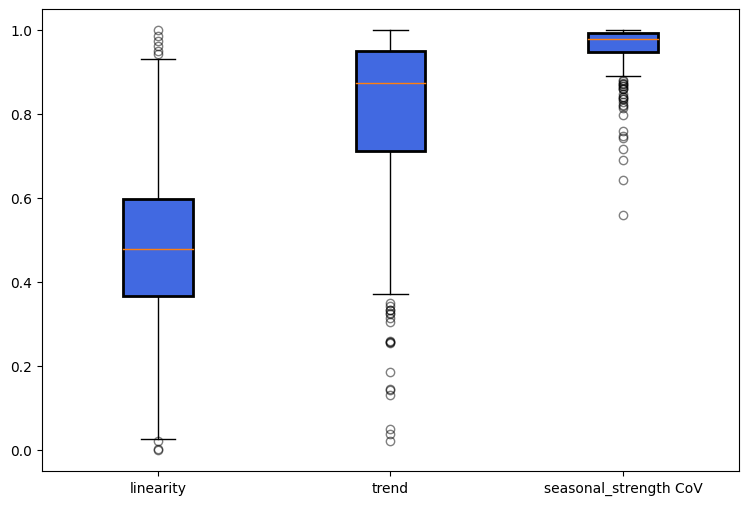

In [20]:
# Three boxplots for lumpiness, entropy and residual_cov on the same figure

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot([features['linearity'], features['trend'], features['seasonal_strength']], patch_artist=True)

# Make the boxplot darkblue and the lines black
for box in bp['boxes']:
    # change outline color
    box.set( color='black', linewidth=2)
    # change fill color to dark blue
    box.set( facecolor = 'royalblue' )

# change the outlier colors
for flier in bp['fliers']:
    flier.set(marker='o', color='black', alpha=0.5)


# Give names
ax.set_xticklabels(['linearity', 'trend', 'seasonal_strength CoV'])

plt.show()

#### Statistical Forecaster

In [21]:
# Define some parameters
freq = 'M'
holdout = True
h = 6
cv = 4
models = ['ETS', 'Naive', 'SNaive', 'CrostonOptimized']

In [22]:
# Define the forecaster
forecaster = StatisticalForecaster(models = models, freq = freq, distributed=True, n_partitions=10)

# Fit the forecaster
forecaster.fit(sample_df, format = 'pivoted')

# predict
forecast_df = forecaster.predict(h = h, cv = cv, holdout = holdout)

2023-04-06 12:11:26,913 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-tg0hj19s', purging
2023-04-06 12:11:26,913 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-yoxhlydx', purging
2023-04-06 12:11:26,913 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-3xspfxme', purging
2023-04-06 12:11:26,914 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-9bghs999', purging


make fugue


/home/filtheo/DeepRetail/.venv/lib/python3.8/site-packages/statsforecast/ets.py:1039: RuntimeWarning: divide by zero encountered in divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/home/filtheo/DeepRetail/.venv/lib/python3.8/site-packages/statsforecast/ets.py:1039: RuntimeWarning: divide by zero encountered in divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/home/filtheo/DeepRetail/.venv/lib/python3.8/site-packages/statsforecast/ets.py:1039: RuntimeWarning: divide by zero encountered in divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/home/filtheo/DeepRetail/.venv/lib/python3.8/site-packages/statsforecast/ets.py:1039: RuntimeWarning: divide by zero encountered in divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/home/filtheo/DeepRetail/.venv/lib/python3.8/site-packages/statsforecast/ets.py:1039: RuntimeWarning: divide by zero encountered in divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/home/filtheo/DeepRetail/.venv/lib/python3.8/site-packages/statsforecast/ets.py:1039: RuntimeWarning

In [23]:
# Evaluate

# Define the evaluator
evaluator = Evaluator(sample_df, forecast_df, freq = freq, format = 'pivoted')
eval_df = evaluator.evaluate(metrics = metrics)

# keep only relevant columns
eval_df

,unique_id,Model,fh,cv,rmsse,scaled_error,mape
6432,GUL_06K21A,Naive,1,1,1.020621,-1.041667,0.000000
6433,GUL_06K21A,Naive,2,1,1.020621,-1.041667,0.000000
6434,GUL_06K21A,Naive,3,1,1.020621,-1.041667,0.000000
6435,GUL_06K21A,Naive,4,1,1.020621,-1.041667,0.000000
6436,GUL_06K21A,Naive,5,1,1.020621,1.041667,0.500000
...,...,...,...,...,...,...,...
32155,TIER_06KB72,CrostonOptimized,5,4,2.743651,2.800227,0.336027
32156,TIER_06KB72,CrostonOptimized,6,4,0.318212,-0.324773,0.062356
32157,TIER_06KB72,CrostonOptimized,7,4,1.723030,1.758560,0.241174
32158,TIER_06KB72,CrostonOptimized,8,4,3.764271,3.841893,0.409802


##### EDA on the Results

In [24]:
# merge eval_df with features on the unique
# groupby on time-series and model
eval_df_ = eval_df.groupby(['unique_id', 'Model']).mean().reset_index()

# add the features
eval_df_ = pd.merge(eval_df_, features, left_on = 'unique_id', right_on = 'unique_id', how = 'left')

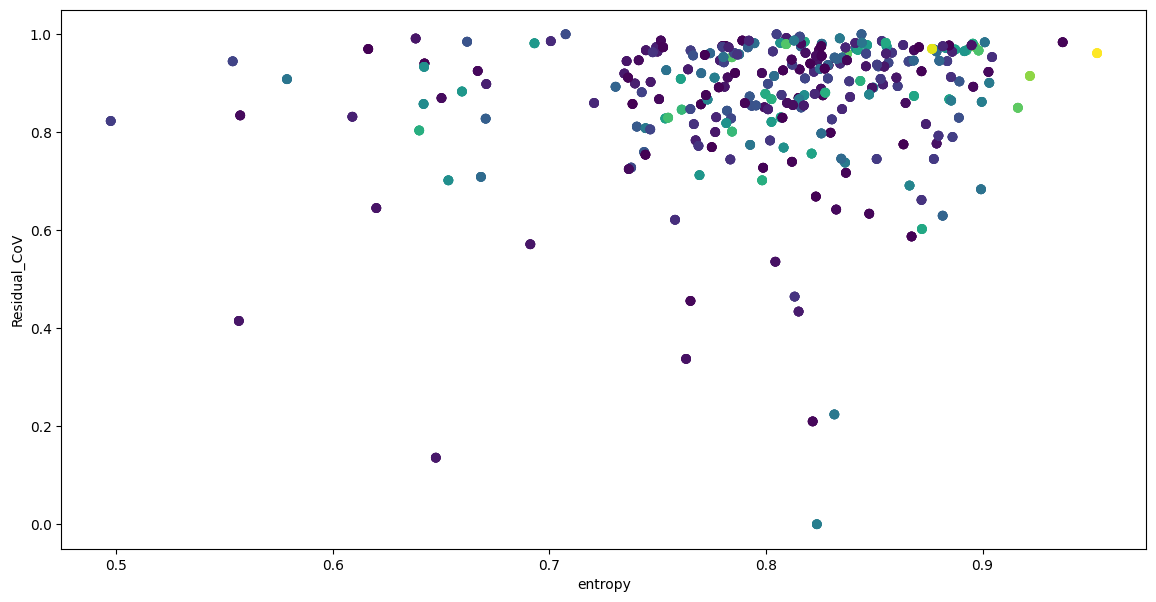

In [25]:
# A scatter plot with entropy on x and Residual_CoV on y 

plt.figure(figsize = (14,7))
plt.scatter(eval_df_['entropy'], eval_df_['Residual_CoV'], c = eval_df_['lumpiness'])

plt.xlabel('entropy')
plt.ylabel('Residual_CoV')
plt.show()



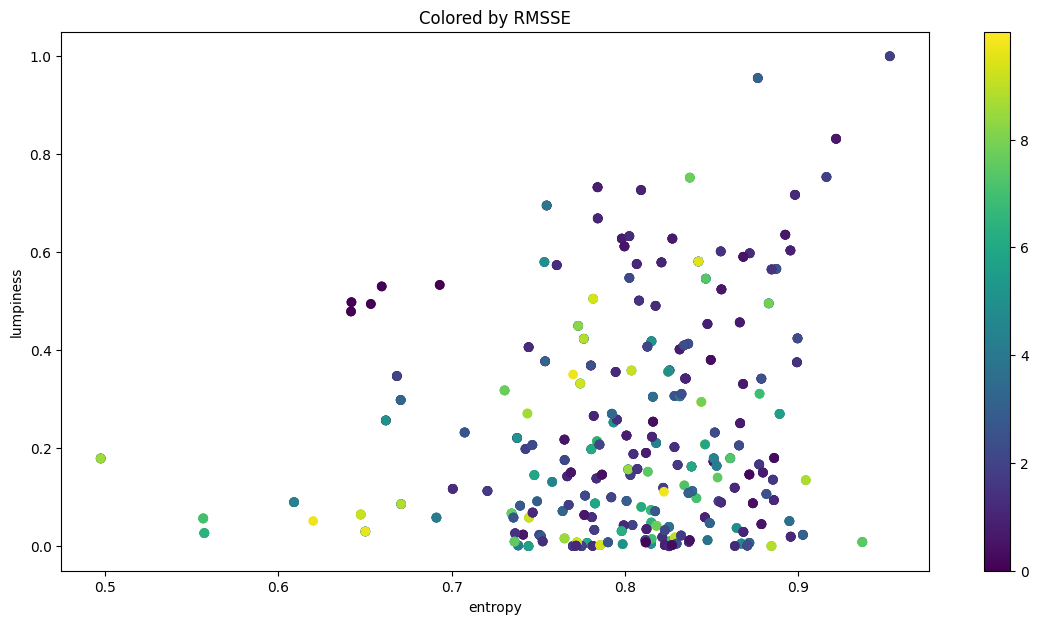

In [26]:
# Scatter plot with rmsse on x and entropy on y color by lumpiness

temp = eval_df_[eval_df_['rmsse']< 10]

plt.figure(figsize=(14,7))
plt.scatter(temp['entropy'], temp['lumpiness'], c = temp['rmsse'], cmap = 'viridis')

plt.xlabel('entropy')
plt.ylabel('lumpiness')
plt.title('Colored by RMSSE')

# a colorbar
plt.colorbar()

plt.show()

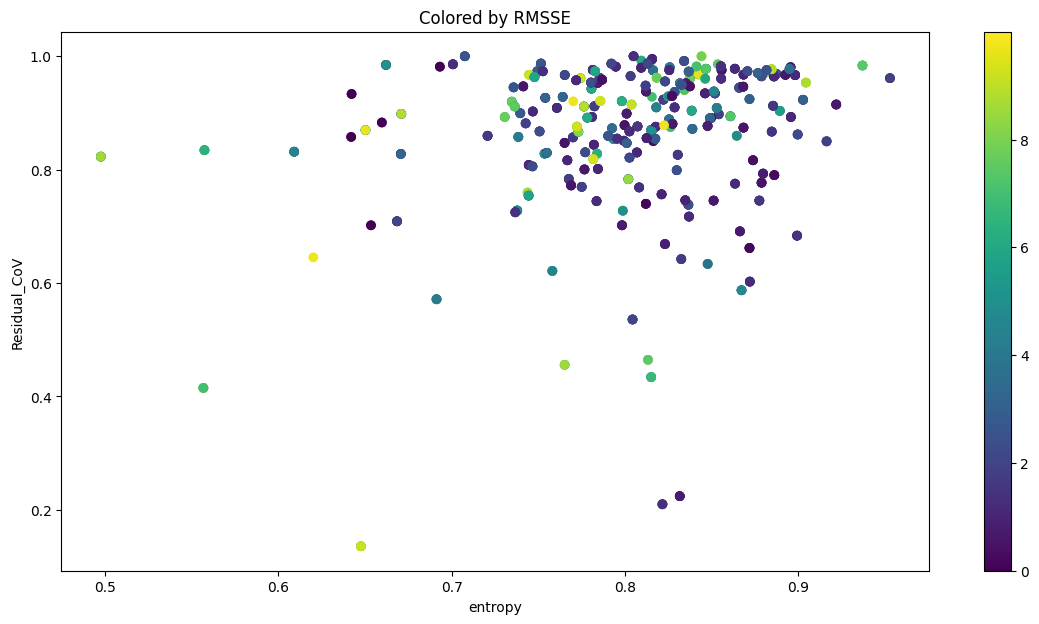

In [27]:
# Scatter plot with rmsse on x and entropy on y color by lumpiness

temp = eval_df_[eval_df_['rmsse']< 10]

plt.figure(figsize=(14,7))
plt.scatter(temp['entropy'], temp['Residual_CoV'], c = temp['rmsse'], cmap = 'viridis')

plt.xlabel('entropy')
plt.ylabel('Residual_CoV')

plt.title('Colored by RMSSE')

# a colorbar
plt.colorbar()

plt.show()

#### LGBM Forecaster

In [28]:
# Define features and transformations 

# Best lag is 11 -> I have already tried
features = {'lags': 17}
transformations = {'normalize': 'StandardScaler'}

# Define model specific
loss_f = 'mae' # Default selection
random_state = 42
model = lgb.LGBMRegressor(objective = loss_f, random_state = random_state, use_missing = True)
model_name = 'lgbm'

In [29]:
lgbm_forecaster = GlobalForecaster(model = model ,
                                    features = features, 
                                    transformations = transformations,
                                    model_name =  model_name)
# Fit 
lgbm_forecaster.fit(sample_df)

# Predict
global_fc = lgbm_forecaster.predict(h = h, cv = cv)

In [30]:
# Define the evaluator
evaluator = Evaluator(sample_df, global_fc, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])
eval_df

,unique_id,Model,fh,cv,rmsse,scaled_error,mape
6432,GUL_06K21A,Naive,1,1,1.020621,-1.041667,0.000000
6433,GUL_06K21A,Naive,2,1,1.020621,-1.041667,0.000000
6434,GUL_06K21A,Naive,3,1,1.020621,-1.041667,0.000000
6435,GUL_06K21A,Naive,4,1,1.020621,-1.041667,0.000000
6436,GUL_06K21A,Naive,5,1,1.020621,1.041667,0.500000
...,...,...,...,...,...,...,...
6427,TIER_06KW2,lgbm,2,4,0.008730,0.000443,0.172029
6428,TIER_06KW2,lgbm,3,4,0.119458,0.006062,0.784633
6429,TIER_06KW2,lgbm,4,4,0.034983,-0.001775,0.000000
6430,TIER_06KW2,lgbm,5,4,0.039023,-0.001980,0.000000


#### Temporal Hierarchies

In [31]:
factors = get_factors(freq = h) # 6 months total -> so factors of 6
factors

array([1, 2, 3, 6])

In [32]:
# Starting with Naive
model = 'Naive'


thief = THieF(bottom_level_freq = freq, factors = factors, holdout = True, cv = cv)

# Fit
thief.fit(sample_df, format = 'pivoted')

# Base forecasts ETS
base_forecasts_naive = thief.predict(model)
res_1 = thief.base_forecast_residuals

# reconcile
method = 'struc' # only supporting struc because of the few number of in-sampel values on top level for reesidusl

rec_fc_1 = thief.reconcile(method = method)

# Rename y_true to True
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Define metrics
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
# Define the evaluator
evaluator = Evaluator(sample_df, temp, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])


In [33]:
# Next with ETS
model = 'ETS'


thief = THieF(bottom_level_freq = freq, factors = factors, holdout = True, cv = cv)

# Fit
thief.fit(sample_df, format = 'pivoted')

# Base forecasts ETS
base_forecasts_ets = thief.predict(model)
res_1 = thief.base_forecast_residuals

# reconcile
method = 'struc' # only supporting struc because of the few number of in-sampel values on top level for reesidusl

rec_fc_1 = thief.reconcile(method = method)

# Rename y_true to True
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Define metrics
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
# Define the evaluator
evaluator = Evaluator(sample_df, temp, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

In [34]:
# Next with ETS
model = 'CrostonOptimized'


thief = THieF(bottom_level_freq = freq, factors = factors, holdout = True, cv = cv)

# Fit
thief.fit(sample_df, format = 'pivoted')

# Base forecasts ETS
base_forecasts_croston = thief.predict(model)
res_1 = thief.base_forecast_residuals

# reconcile
method = 'struc' # only supporting struc because of the few number of in-sampel values on top level for reesidusl

rec_fc_1 = thief.reconcile(method = method)

# Rename y_true to True
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Define metrics
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
# Define the evaluator
evaluator = Evaluator(sample_df, temp, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

In [35]:
# Base forecast combinations

# concat all base forecasts
base_forecasts_combined = pd.concat([base_forecasts_naive, base_forecasts_ets, base_forecasts_croston])

# Take the mean and the median per unique_id, temporal_level, fh,cv 
base_forecasts_combined = base_forecasts_combined.groupby(['unique_id', 'temporal_level', 'fh', 'cv']).agg({'y': ['mean', 'median'],'y_true':'first', 'date':'first' }).reset_index()

# unstack columns
base_forecasts_combined.columns = base_forecasts_combined.columns.map('_'.join).str.strip('_')
# Drop the "_first" suffix from the last 2 columns
base_forecasts_combined = base_forecasts_combined.rename(columns = {'y_true_first': 'y_true', 'date_first': 'date'})

# take two seperate dfs, one for t he mean one for the median
base_forecasts_combined_mean = base_forecasts_combined[['unique_id', 'temporal_level', 'fh', 'cv', 'y_mean', 'y_true', 'date']]
# Rename y_mean to y
base_forecasts_combined_mean = base_forecasts_combined_mean.rename(columns = {'y_mean': 'y'})
base_forecasts_combined_mean['Model'] = 'Mean_Combination'

base_forecasts_combined_median = base_forecasts_combined[['unique_id', 'temporal_level', 'fh', 'cv', 'y_median', 'y_true', 'date']]
# Rename y_median to y
base_forecasts_combined_median = base_forecasts_combined_median.rename(columns = {'y_median': 'y'})
base_forecasts_combined_median['Model'] = 'Median_Combination'

In [36]:
# Reconcile
# Define a reconciler 
temporal_reconciler = TemporalReconciler(bottom_level_freq = freq, factors=factors, holdout = holdout, cv = cv)

# Fit the reconcilcer
temporal_reconciler.fit(base_forecasts_combined_mean)

# Reconcile
rec_fc_1 = temporal_reconciler.reconcile('struc', residual_df = res_1)
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Evaluate
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
evaluator = Evaluator(sample_df, rec_fc_1, freq = freq)

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

In [37]:
# Reconcile
# Define a reconciler 
temporal_reconciler = TemporalReconciler(bottom_level_freq = freq, factors=factors, holdout = holdout, cv = cv)

# Fit the reconcilcer
temporal_reconciler.fit(base_forecasts_combined_median)

# Reconcile
rec_fc_1 = temporal_reconciler.reconcile('struc', residual_df = res_1)
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Evaluate
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
evaluator = Evaluator(sample_df, rec_fc_1, freq = freq)

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

#### Cross-Sectional

In [38]:
# Initialize Arguments
current = ['Brand', 'ID']
correct = ['ID', 'Brand']
splitter = '_'
total = True

In [39]:
# Start with Naive
model = 'Naive'


# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = sample_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_naive = chief.predict(models = [model])
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
rec_extended = rec_extended[rec_extended['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(chief.cross_sectional_df, rec_extended, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [40]:
# Start with Naive
model = 'ETS'


# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = sample_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_ets = chief.predict(models = [model])
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
rec_extended = rec_extended[rec_extended['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(chief.cross_sectional_df, rec_extended, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [41]:
# Start with Naive
model = 'CrostonOptimized'


# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = sample_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_croston = chief.predict(models = [model])
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
rec_extended = rec_extended[rec_extended['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(chief.cross_sectional_df, rec_extended, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [42]:
# Base forecast combinations

# Extend forecasts to include the hierarchical level
base_forecasts_naive = hierarchical_to_transaction(base_forecasts_naive, chief.hierarchical_format, sort_by = False, format = 'transaction')
base_forecasts_ets = hierarchical_to_transaction(base_forecasts_ets, chief.hierarchical_format, sort_by = False, format = 'transaction')
base_forecasts_croston = hierarchical_to_transaction(base_forecasts_croston, chief.hierarchical_format, sort_by = False, format = 'transaction')


# concat all base forecasts
base_forecasts_combined = pd.concat([base_forecasts_naive, base_forecasts_ets, base_forecasts_croston])

# Take the mean and the median per unique_id, temporal_level, fh,cv 
base_forecasts_combined = base_forecasts_combined.groupby(['unique_id', 'cross_sectional_level', 'fh', 'cv']).agg({'y': ['mean', 'median'],'True':'first', 'date':'first' }).reset_index()

# unstack columns
base_forecasts_combined.columns = base_forecasts_combined.columns.map('_'.join).str.strip('_')
# Drop the "_first" suffix from the last 2 columns
base_forecasts_combined = base_forecasts_combined.rename(columns = {'True_first': 'True', 'date_first': 'date'})

# take two seperate dfs, one for t he mean one for the median
base_forecasts_combined_mean = base_forecasts_combined[['unique_id', 'cross_sectional_level', 'fh', 'cv', 'y_mean', 'True', 'date']]
# Rename y_mean to y
base_forecasts_combined_mean = base_forecasts_combined_mean.rename(columns = {'y_mean': 'y'})
base_forecasts_combined_mean['Model'] = 'Mean_Combination'

base_forecasts_combined_median = base_forecasts_combined[['unique_id', 'cross_sectional_level', 'fh', 'cv', 'y_median', 'True', 'date']]
# Rename y_median to y
base_forecasts_combined_median = base_forecasts_combined_median.rename(columns = {'y_median': 'y'})
base_forecasts_combined_median['Model'] = 'Median_Combination'

base_forecasts_combined_median

,unique_id,cross_sectional_level,fh,cv,y,True,date,Model
0,T,total,1,1,15648.496094,14525.0,2021-06-30,Median_Combination
1,T,total,2,1,15648.496094,15838.0,2021-07-31,Median_Combination
2,T,total,2,2,15235.484375,15838.0,2021-07-31,Median_Combination
3,T,total,3,1,15648.496094,19250.0,2021-08-31,Median_Combination
4,T,total,3,2,15235.484375,19250.0,2021-08-31,Median_Combination
...,...,...,...,...,...,...,...,...
6667,T_TIE_06KB84,ID,7,3,1.318267,0.0,2021-12-31,Median_Combination
6668,T_TIE_06KB84,ID,7,4,1.252303,0.0,2021-12-31,Median_Combination
6669,T_TIE_06KB84,ID,8,3,1.318267,0.0,2022-01-31,Median_Combination
6670,T_TIE_06KB84,ID,8,4,1.252303,0.0,2022-01-31,Median_Combination


In [43]:
# Define the reconciler
reconciler = CrossSectionalReconciler(bottom_level_freq=freq, h = h, holdout = holdout, cv = cv)

# fit the reconciler
reconciler.fit(df = base_forecasts_combined_median, s_mat = chief.S_mat)

# reconcile
reconciled_forecasts = reconciler.reconcile(method = 'struc')

reconciled_forecasts = reconciled_forecasts[reconciled_forecasts['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
reconciled_forecasts = reconciled_forecasts.rename(columns = {'y_pred':'y'})

evaluator = Evaluator(chief.cross_sectional_df, reconciled_forecasts, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [44]:
# Define the reconciler
reconciler = CrossSectionalReconciler(bottom_level_freq=freq, h = h, holdout = holdout, cv = cv)

# fit the reconciler
reconciler.fit(df = base_forecasts_combined_mean, s_mat = chief.S_mat)

# reconcile
reconciled_forecasts = reconciler.reconcile(method = 'struc')

reconciled_forecasts = reconciled_forecasts[reconciled_forecasts['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
reconciled_forecasts = reconciled_forecasts.rename(columns = {'y_pred':'y'})

evaluator = Evaluator(chief.cross_sectional_df, reconciled_forecasts, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

#### Cross-Temporal

In [45]:
# Start with Naive
models = 'Naive'

# Define the object
ct = C_THieF(bottom_level_freq=freq, factors = factors, h = h, holdout = holdout, cv = cv)

# Fit to build the hierarchical structures
ct.fit(df = sample_df, 
       current_format = current, 
       corrected_format = correct, 
       splitter = splitter, 
       add_total = total,
       format = 'pivoted')


# Generate base forecasts for each cross-sectional and temporal level
base_forecasts_naive = ct.predict(models = models)

# Reconcile
rec = ct.reconcile('struc', 'struc')

# Evaluate

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-Naive'
# Concat
eval_df = pd.concat([eval_df, eval_df_new])


In [46]:
# Start with Naive
models = 'ETS'

# Define the object
ct = C_THieF(bottom_level_freq=freq, factors = factors, h = h, holdout = holdout, cv = cv)

# Fit to build the hierarchical structures
ct.fit(df = sample_df, 
       current_format = current, 
       corrected_format = correct, 
       splitter = splitter, 
       add_total = total,
       format = 'pivoted')


# Generate base forecasts for each cross-sectional and temporal level
base_forecasts_ets = ct.predict(models = models)

# Reconcile
rec = ct.reconcile('struc', 'struc')

# Evaluate

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-ETS'
# Concat
eval_df = pd.concat([eval_df, eval_df_new])


In [47]:
# Start with Naive
models = 'CrostonOptimized'

# Define the object
ct = C_THieF(bottom_level_freq=freq, factors = factors, h = h, holdout = holdout, cv = cv)

# Fit to build the hierarchical structures
ct.fit(df = sample_df, 
       current_format = current, 
       corrected_format = correct, 
       splitter = splitter, 
       add_total = total,
       format = 'pivoted')


# Generate base forecasts for each cross-sectional and temporal level
base_forecasts_croston = ct.predict(models = models)

# Reconcile
rec = ct.reconcile('struc', 'struc')

# Evaluate

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-CrostonOptimized'

# Concat
eval_df = pd.concat([eval_df, eval_df_new])


In [48]:
# Base forecast combinations
# Change some types
base_forecasts_naive['cross_sectional_level'] = base_forecasts_naive['cross_sectional_level'].astype(str)
base_forecasts_ets['cross_sectional_level'] = base_forecasts_ets['cross_sectional_level'].astype(str)
base_forecasts_croston['cross_sectional_level'] = base_forecasts_croston['cross_sectional_level'].astype(str)

# concat all base forecasts
base_forecasts_combined = pd.concat([base_forecasts_naive, base_forecasts_ets, base_forecasts_croston])

# Take the mean and the median per unique_id, temporal_level, fh,cv 
base_forecasts_combined = base_forecasts_combined.groupby(['unique_id', 'temporal_level', 'cross_sectional_level', 'fh', 'cv']).agg({'y': ['mean', 'median'],'y_true':'first', 'date':'first' }).reset_index()

# unstack columns
base_forecasts_combined.columns = base_forecasts_combined.columns.map('_'.join).str.strip('_')
# Drop the "_first" suffix from the last 2 columns
base_forecasts_combined = base_forecasts_combined.rename(columns = {'y_true_first': 'y_true', 'date_first': 'date'})

# take two seperate dfs, one for t he mean one for the median
base_forecasts_combined_mean = base_forecasts_combined[['unique_id', 'temporal_level', 'cross_sectional_level', 'fh', 'cv', 'y_mean', 'y_true', 'date']]
# Rename y_mean to y
base_forecasts_combined_mean = base_forecasts_combined_mean.rename(columns = {'y_mean': 'y'})
base_forecasts_combined_mean['Model'] = 'Mean_Combination'

base_forecasts_combined_median = base_forecasts_combined[['unique_id', 'temporal_level', 'cross_sectional_level', 'fh', 'cv', 'y_median', 'y_true', 'date']]
# Rename y_median to y
base_forecasts_combined_median = base_forecasts_combined_median.rename(columns = {'y_median': 'y'})
base_forecasts_combined_median['Model'] = 'Median_Combination'

In [49]:
cross_temporal_reconciler = CrossTemporalReconciler(bottom_level_freq = freq, factors = factors, h = h, holdout = holdout, cv = cv)

# fit
cross_temporal_reconciler.fit(base_forecasts_combined_median, cross_sectional_Smat = ct.s_mat_cross, residual_df = ct.residuals)

# Reconcile
rec = cross_temporal_reconciler.reconcile('struc', 'struc')

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-Median_Combination'

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [50]:
cross_temporal_reconciler = CrossTemporalReconciler(bottom_level_freq = freq, factors = factors, h = h, holdout = holdout, cv = cv)

# fit
cross_temporal_reconciler.fit(base_forecasts_combined_mean, cross_sectional_Smat = ct.s_mat_cross, residual_df = ct.residuals)

# Reconcile
rec = cross_temporal_reconciler.reconcile('struc', 'struc')

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-Mean_Combination'
# Concat
eval_df = pd.concat([eval_df, eval_df_new])

#### Analyze Results

In [51]:
# Drop any duplicates
eval_df = eval_df.drop_duplicates(subset = ['unique_id', 'Model', 'fh', 'cv'])

In [52]:
# Best model
eval_df.groupby(['Model']).mean().reset_index().drop('cv', axis = 1).sort_values('mape')

,Model,rmsse,scaled_error,mape
19,lgbm,0.316154,-0.000215,0.308074
15,TR-struc-CrostonOptimized,1.010253,0.003607,0.414756
6,CrostonOptimized,21.632054,-4.233910,0.444474
3,CTR-struc-Mean_Combination,0.869722,0.004366,0.454984
16,TR-struc-Mean_Combination,1.607118,0.009731,0.458448
5,CTR-struc-Naive,0.858011,0.002075,0.474815
18,TR-struc-Naive,0.858011,0.002075,0.474815
0,AutoETS,16.288311,1.043366,0.475478
2,CTR-struc-ETS,0.845398,0.002594,0.475568
4,CTR-struc-Median_Combination,0.848203,0.002538,0.476239


In [53]:
# Best model no outliers
eval_df[eval_df['rmsse'] < 10].groupby(['Model']).mean().reset_index().drop('cv', axis = 1).sort_values('mape')

,Model,rmsse,scaled_error,mape
19,lgbm,0.286063,0.000184,0.307712
15,TR-struc-CrostonOptimized,0.511455,0.001814,0.418561
6,CrostonOptimized,2.450745,-0.811872,0.422477
0,AutoETS,2.228652,-0.630211,0.427252
12,Naive,2.104854,-0.042735,0.450728
3,CTR-struc-Mean_Combination,0.544191,-0.004200,0.454861
16,TR-struc-Mean_Combination,0.735727,0.001289,0.464665
5,CTR-struc-Naive,0.497922,-0.004330,0.474624
18,TR-struc-Naive,0.497922,-0.004330,0.474624
2,CTR-struc-ETS,0.497799,-0.004227,0.475498


In [54]:
import seaborn as sns

In [55]:
def classify_techniques(model):
    if 'CTR' in model:
        out = 'Cross_Temporal'
    elif 'TR' in model:
        out = 'Temporal'
    elif 'HR' in model:
        out = 'Cross_Sectional'
    else:
        out = 'Base'
    return out

In [64]:
eval_df_group.groupby('Model').mean()

,rmsse,scaled_error,mape
Model,,,
AutoETS,6.311442,-0.014331,0.492313
CTR-struc-CrostonOptimized,0.375556,0.007744,0.590512
CTR-struc-ETS,0.323031,-0.000829,0.493268
CTR-struc-Mean_Combination,0.317993,0.001965,0.472449
CTR-struc-Median_Combination,0.323361,-0.000882,0.493923
CTR-struc-Naive,0.323875,-0.001020,0.492091
CrostonOptimized,7.344765,-1.129431,0.460685
HR-struc-AutoETS,0.350974,0.005086,0.689845
HR-struc-CrostonOptimized,0.492966,0.011540,1.245258


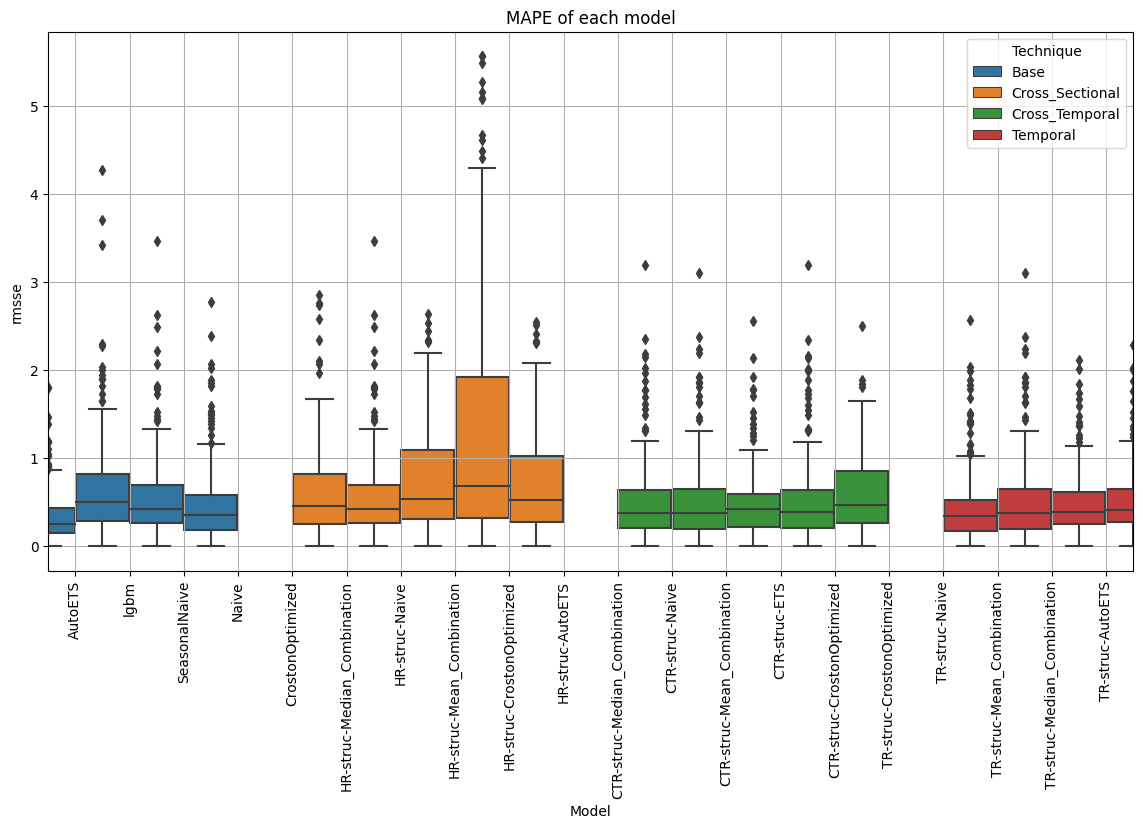

In [66]:
# remove out
remove_out = True
total_outliers = 20

eval_df_group = eval_df.groupby(['unique_id','Model']).mean().reset_index().drop('cv', axis = 1)
# classify techniques
eval_df_group['Technique'] = eval_df_group['Model'].apply(classify_techniques)

# find the outlier series
# mean rmsse over 50
outliers = eval_df_group.groupby(['unique_id']).mean().reset_index().sort_values('rmsse', ascending = False).head(total_outliers)['unique_id'].values

if remove_out:
    eval_df_group = eval_df_group[~eval_df_group['unique_id'].isin(outliers)]

# Remove outlier mapes
#eval_df_group = eval_df_group[eval_df_group['rmsse'] < 10]

# A boxplot for the rmsse of each model on the eval_df_group df
# Models should be grouped based on the Technique

# Sort the dataframe based on the technique
eval_df_group = eval_df_group.sort_values('Technique')

# Figure
fig, ax = plt.subplots(figsize = (14, 7))

# Boxplots, color should be based on the technique
# Distance and width should be adjusted
sns.boxplot(x = 'Model', y = 'mape', data = eval_df_group, ax = ax, hue = 'Technique', width = 4)

ax.grid()

ax.set_title('MAPE of each model')

ax.set_xlabel('Model')

ax.set_ylabel('rmsse')

plt.xticks(rotation = 90)

plt.show()

